## ETL process

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [49]:
#Load data set
s3_url_train = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/train.csv"
data_frame = pd.read_csv(s3_url_train)

In [50]:
#Print the features of the data set
data_frame.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [51]:
#Print the first 5 rows of the data set
data_frame.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#Pandas profiling on the data frame
from ydata_profiling import ProfileReport
profile = ProfileReport(data_frame, title="Pandas Profiling Report")
profile

Feature Engineering

In [52]:
#PCA to transform correlated features into uncorrelated principal components
#Drop unnecessary columns
data_frame = data_frame.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
#Columns left in the data frame

le = LabelEncoder()
data_frame['Sex'] = le.fit_transform(data_frame['Sex']) # male = 1, female = 0

#Fill missing embarged values with the most common value class which is S
data_frame['Embarked'] = data_frame['Embarked'].fillna('S') # Which is the mode of the column, and a cetegorical value
data_frame['Embarked'] = le.fit_transform(data_frame['Embarked']) 

#Handle data frame missing values
data_frame['Age'] = data_frame['Age'].fillna(data_frame['Age'].median())  
data_frame['Fare'] = data_frame['Fare'].fillna(data_frame['Fare'].median())

scaler = StandardScaler()
data_frame_scaled = scaler.fit_transform(data_frame)

In [26]:
#Verify changes in the data frame
data_frame.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [27]:
#Check for any null values left 
data_frame.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [28]:
#Execute PCA
pca = PCA(n_components=8)
principal_components = pca.fit_transform(data_frame_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(8)])

print(df_pca.head())
print("")
print("Explained variance ratio: ", pca.explained_variance_ratio_)
print("")
print("Total variance explained: ", sum(pca.explained_variance_ratio_))

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.563770  0.539987 -0.215762 -0.116627 -0.477053  0.363546 -0.119260   
1  2.766531 -0.972373  0.511362 -0.850116  0.525212  1.033726  0.135976   
2  0.239741  0.362723  1.922108  0.975713  0.042381  0.232248 -0.325721   
3  1.934646 -0.425023  0.347982  1.303292 -0.422448  0.917313  0.043790   
4 -1.595226 -0.450133 -0.180179  0.269208  0.148363 -0.096814 -0.229886   

        PC8  
0  0.090225  
1 -0.439624  
2  0.478148  
3 -0.500323  
4  0.363797  

Explained variance ratio:  [0.27237544 0.21434605 0.1461328  0.11720043 0.08635565 0.06996765
 0.05221954 0.04140245]

Total variance explained:  1.0


Distributions

Feature:  PC1

Feature:  PC2

Feature:  PC3

Feature:  PC4

Feature:  PC5

Feature:  PC6

Feature:  PC7


c:\Users\danyO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()



Feature:  PC8



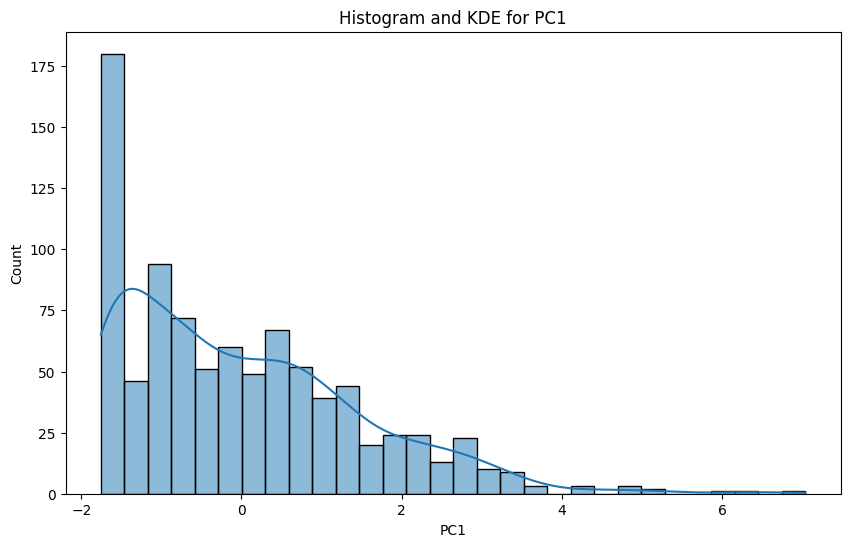

<Figure size 600x600 with 0 Axes>

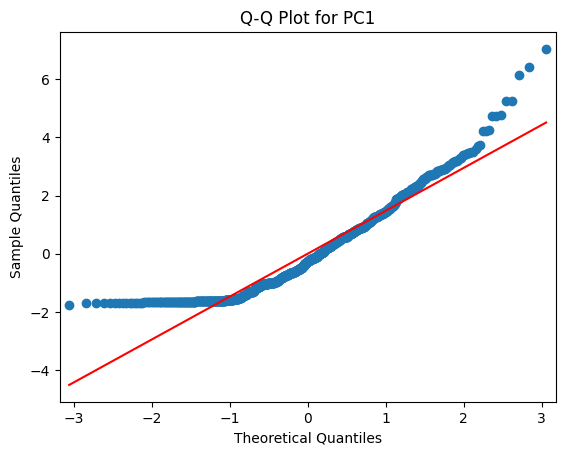

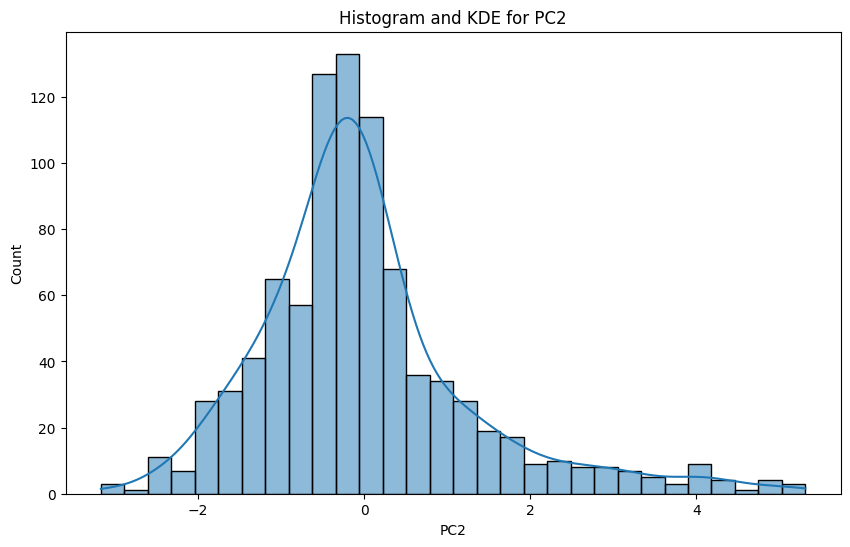

<Figure size 600x600 with 0 Axes>

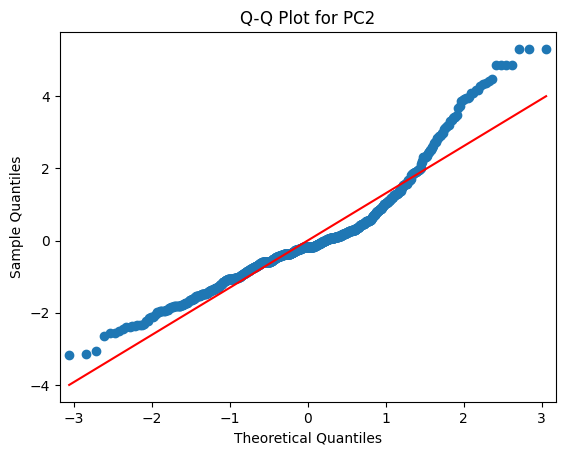

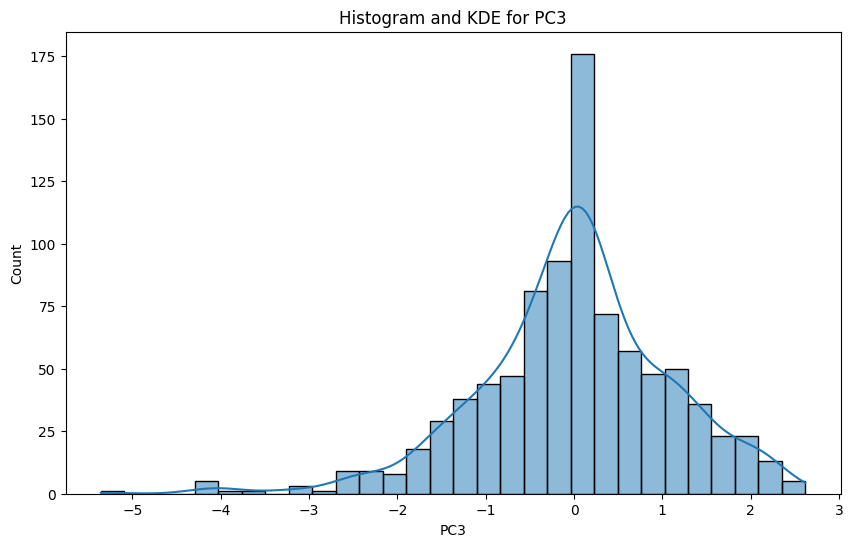

<Figure size 600x600 with 0 Axes>

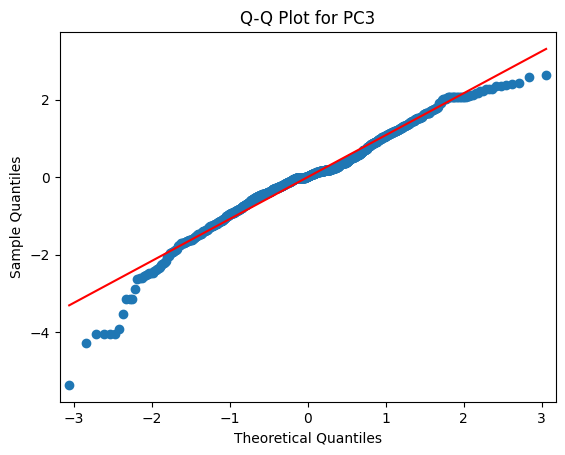

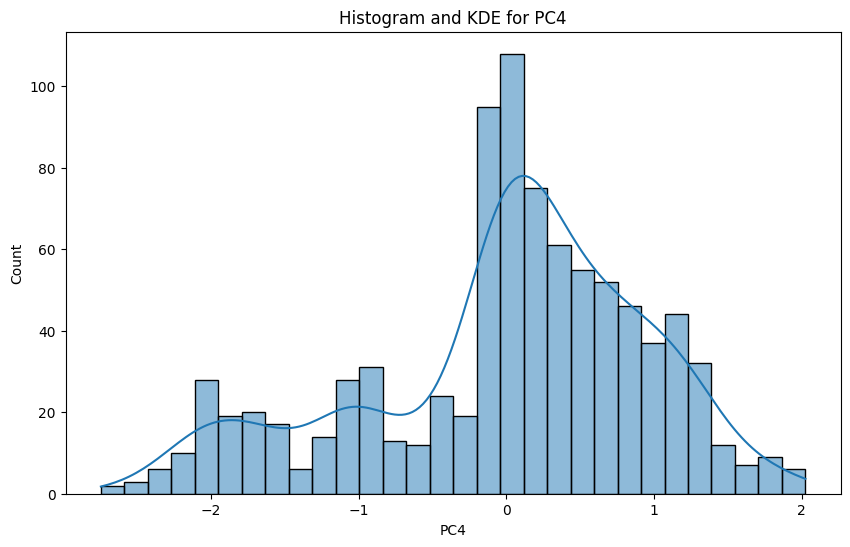

<Figure size 600x600 with 0 Axes>

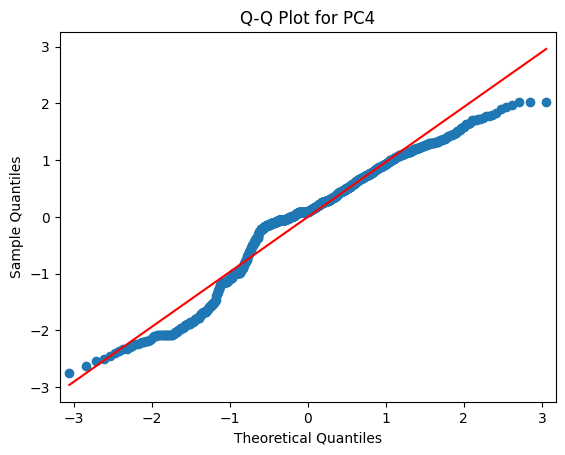

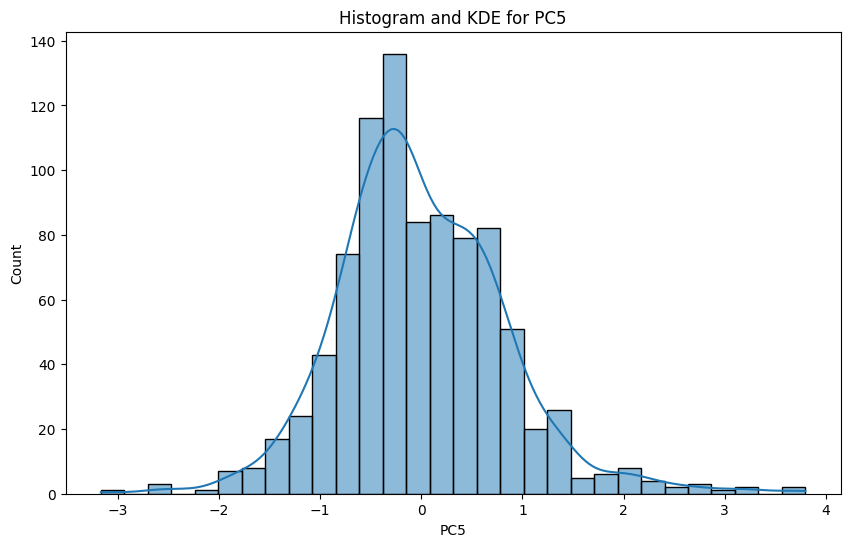

<Figure size 600x600 with 0 Axes>

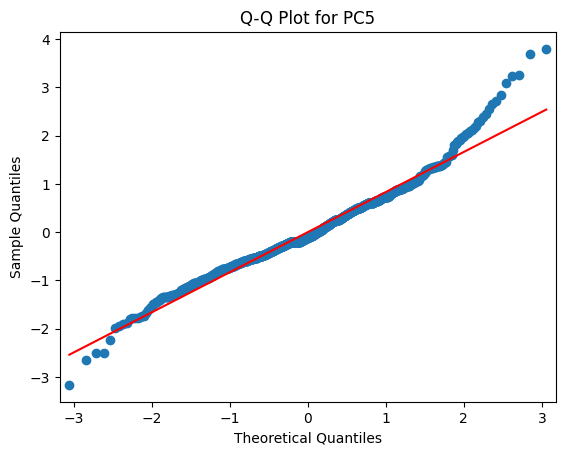

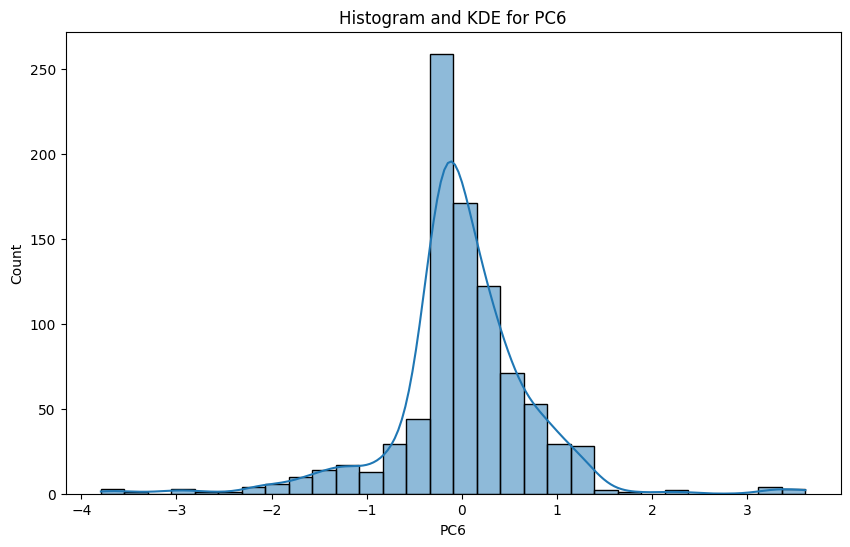

<Figure size 600x600 with 0 Axes>

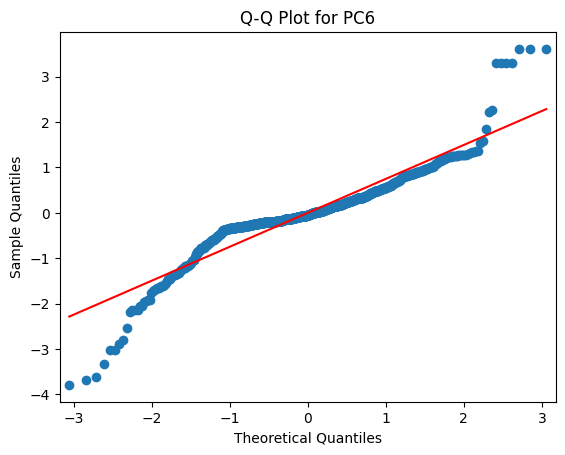

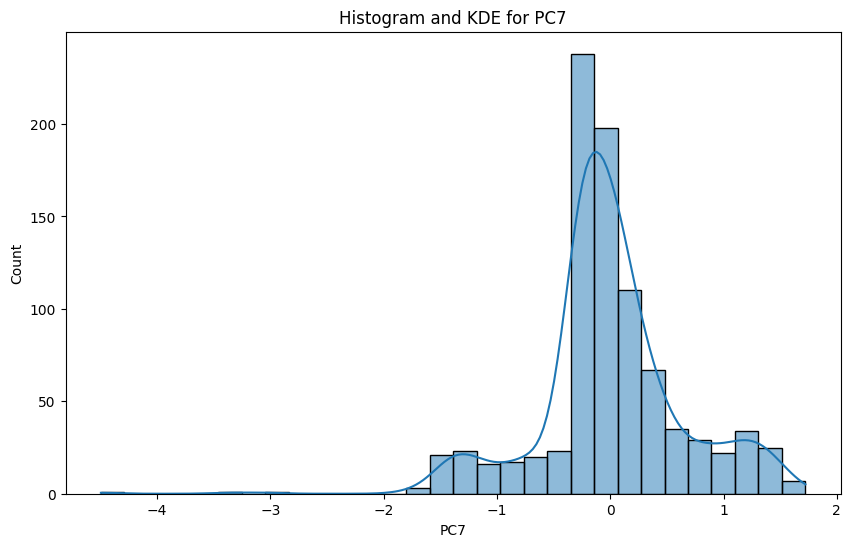

<Figure size 600x600 with 0 Axes>

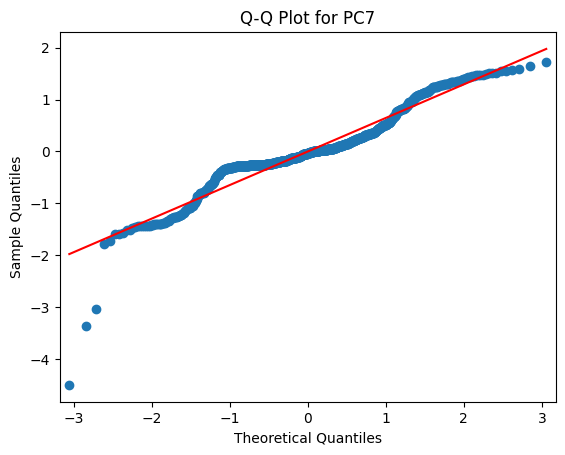

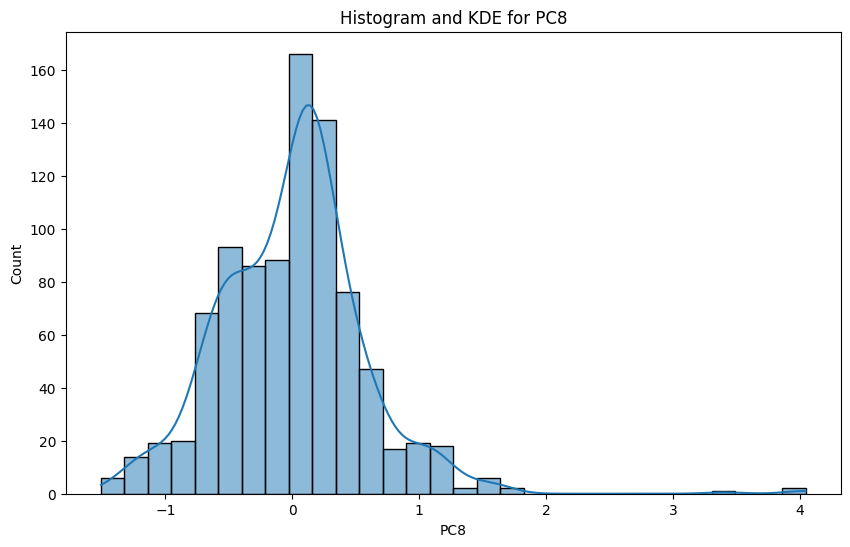

<Figure size 600x600 with 0 Axes>

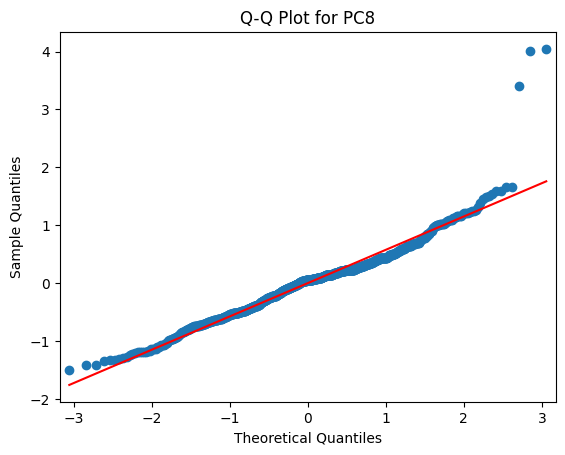

In [29]:
# Analaize the data distribution of the principal components
numeric_features = df_pca.select_dtypes(include=[np.number]).columns

for feature in numeric_features:
    data = df_pca[feature]

    print("Feature: ", feature)

    #Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True, bins=30)
    plt.title(f'Histogram and KDE for {feature}')
    plt.savefig(f'{feature}_histogram.png')

    #QQ plot 
    plt.figure(figsize=(6, 6))
    qqplot(data, line='s')
    plt.title(f'Q-Q Plot for {feature}')
    plt.savefig(f'{feature}_qqplot.png')

    print("")

Corelation Analysis

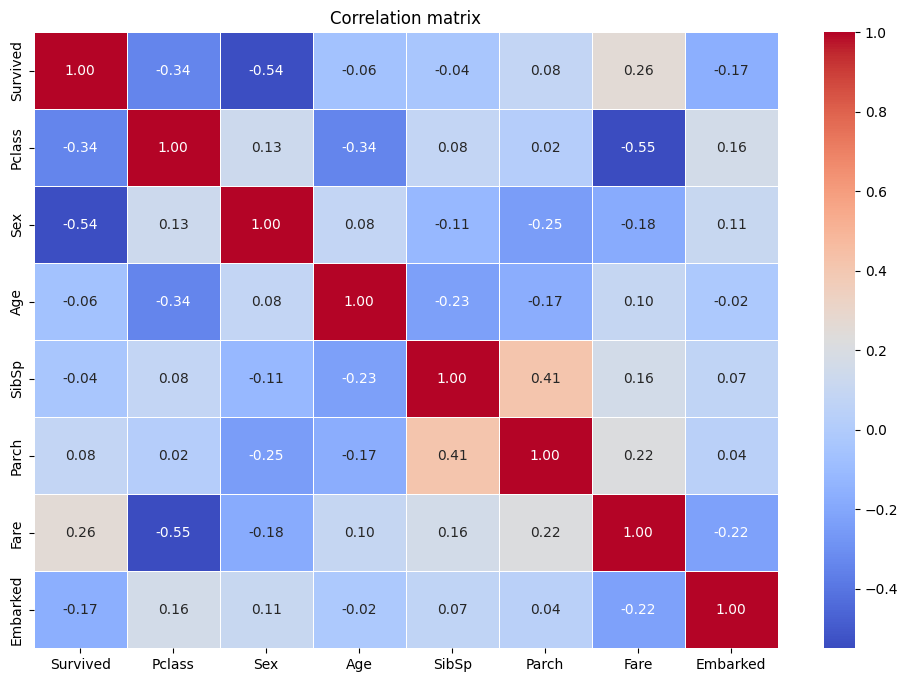

In [30]:
#Correlation matrix
correlation_matrix = data_frame.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation matrix')
plt.savefig('correlation_matrix.png')

## Classification

1. Logistic Regresion:

Justification: Powerful algorithm for binary classification problems like predicting survival in this case survived or not survided. Plus it is easily interpretable.

In [31]:
#Logistic regression
#Features and target variable for training
X_train, y_train = data_frame[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']], data_frame['Survived']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [32]:
#Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [33]:
#Import test data set
survived_data_frame = pd.read_csv('gender_submission.csv')
data_frame_test = pd.read_csv('test.csv')

data_frame_test = pd.merge(data_frame_test, survived_data_frame, on='PassengerId')

In [ ]:
#Drop unnecessary columns
data_frame_test = data_frame_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

#Transform the data frame
data_frame_test['Sex'] = le.fit_transform(data_frame_test['Sex'])

data_frame_test['Embarked'] = data_frame_test['Embarked'].fillna('S')
data_frame_test['Embarked'] = le.fit_transform(data_frame_test['Embarked'])

data_frame_test['Age'] = data_frame_test['Age'].fillna(data_frame_test['Age'].median())
data_frame_test['Fare'] = data_frame_test['Fare'].fillna(data_frame_test['Fare'].median())

X_test, y_test = data_frame_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']], data_frame_test['Survived']

X_test_scaled = scaler.transform(X_test)

In [36]:
data_frame_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,34.5,0,0,7.8292,1,0
1,3,0,47.0,1,0,7.0000,2,1
2,2,1,62.0,0,0,9.6875,1,0
3,3,1,27.0,0,0,8.6625,2,0
4,3,0,22.0,1,1,12.2875,2,1


In [37]:
#Make predictions on the training set
y_pred = model.predict(X_test_scaled)

Accuracy:  0.9449760765550239
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       266
           1       0.91      0.95      0.93       152

    accuracy                           0.94       418
   macro avg       0.94      0.95      0.94       418
weighted avg       0.95      0.94      0.95       418



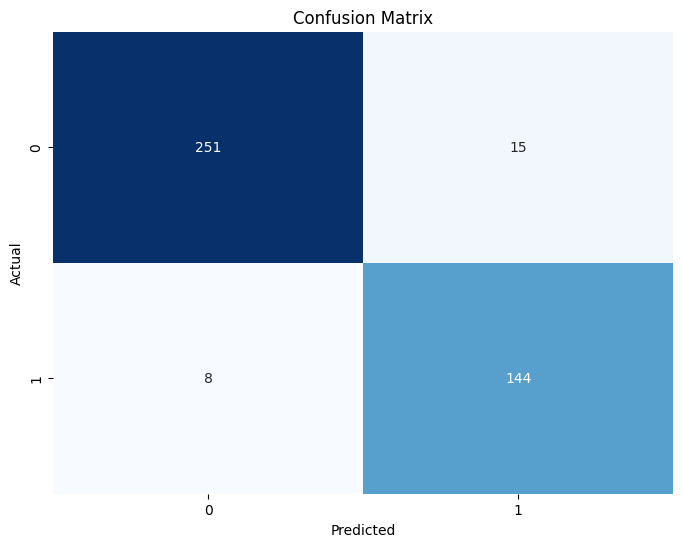

In [38]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

print("Classification report: ")
print(classification_report(y_test, y_pred))

2. Random Forest:

Justification: Given the Titanic dataset’s diversity in features (like age, fare, class, etc.), Random Forest can effectively capture the non-linear relationships between features and survival.

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Separar las variables predictoras (X) de la variable objetivo (y)
X = data_frame_scaled
y = data_frame['Survived']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Hacer predicciones
y_pred = rf_model.predict(X_test)

# 5. Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        74

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

Confusion Matrix:
 [[105   0]
 [  0  74]]


C:\Users\danyO\AppData\Local\Temp\ipykernel_7768\3873074312.py:25: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


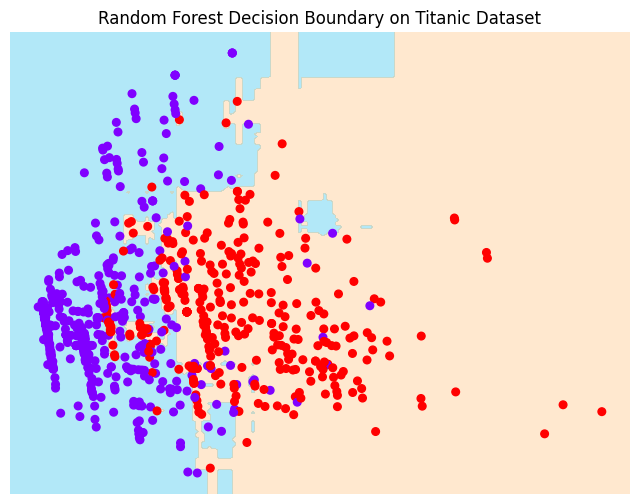

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Función de visualización del clasificador
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

# Reducir dimensiones con PCA a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_frame_scaled)

# Inicializar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Visualizar el clasificador
plt.figure(figsize=(8, 6))
visualize_classifier(rf_model, X_pca, data_frame['Survived'])
plt.title('Random Forest Decision Boundary on Titanic Dataset')
plt.show()


Accuracy:  1.0
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        74

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



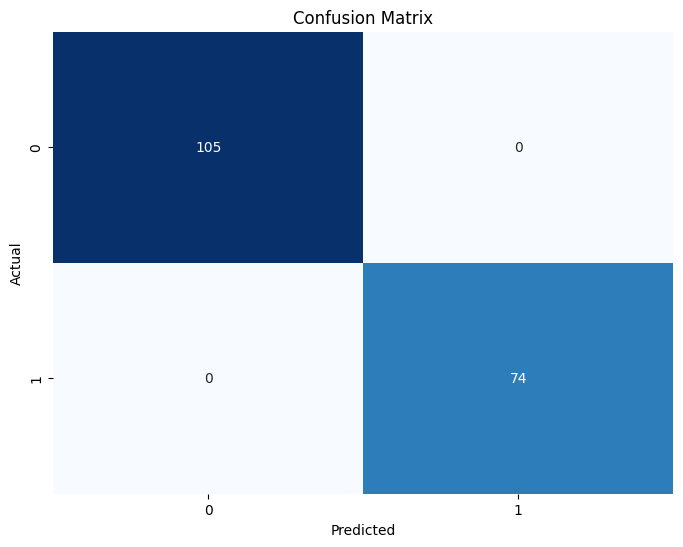

In [56]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

print("Classification report: ")
print(classification_report(y_test, y_pred))

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# 2. Configurar K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # K = 10

# 3. Aplicar K-Fold Cross Validation
scores = cross_val_score(rf_model, data_frame_scaled, data_frame['Survived'], cv=kf, scoring='accuracy')

# 4. Mostrar los resultados
print(f"Scores for each fold: {scores}")
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")


Scores for each fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0


3. Support Vector Machine (SVM):

Justification: SVM can efficiently classify data points even when the relationship between the features and the target variable is complex.

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
model = SVC()
param_grid = {'C':[1,2,5,10,20,50]} 
grs = GridSearchCV(model, param_grid=param_grid, cv = 10, n_jobs=1, return_train_score = False)
grs.fit(np.array(data_frame[features]), np.array(data_frame['Survived']))

GridSearchCV(cv=10, estimator=SVC(), n_jobs=1,
             param_grid={'C': [1, 2, 5, 10, 20, 50]})

In [27]:
print("Best parameters " + str(grs.best_params_))
gpd = pd.DataFrame(grs.cv_results_)
print("Estimated accuracy of this model for unseen data:{0:1.4f}".format(gpd['mean_test_score'][grs.best_index_]))

Best parameters {'C': 50}
Estimated accuracy of this model for unseen data:0.7890


In [32]:
s3_url_test = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/test.csv"
data_frame_test = pd.read_csv(s3_url_test)
data_frame_test['Sex'] = le.fit_transform(data_frame_test['Sex'])
data_frame_test['Embarked'] = data_frame_test['Embarked'].fillna('S')
data_frame_test['Embarked'] = le.fit_transform(data_frame_test['Embarked']) 

data_frame_test['Age'] = data_frame_test['Age'].fillna(data_frame_test['Age'].median())  
data_frame_test['Fare'] = data_frame_test['Fare'].fillna(data_frame_test['Fare'].median())
pred = grs.predict(np.array(data_frame_test[features]))

sub = pd.DataFrame({'PassengerId':data_frame_test['PassengerId'],'Survived':pred})
sub.to_csv('AgeSexPclassEmbarked.csv', index = False, float_format='%1d')
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## K-cross validation